# GeoConnex

In [1]:
import geopandas as gpd
import pandas as pd
import pynhd
from pynhd import GeoConnex

[GeoConnex](https://geoconnex.internetofwater.dev/) is a web service developed by [Internet Of Water](https://internetofwater.org/) that provides access to many hydro-linked datasets. PyNHD provides access to all GeoConnex endpoints.

For single queries it's recommended to use the `pynhd.geoconnex` function and for multiple queries, it's more efficient to directly use the underlying `pynhd.GeoConnex` class that the `pynhd.geoconnex` function calls under-the-hood.

Let's start by the `geoconnex` function. If you run the function without any arguments, it will print out a list of available endpoints. Moreover, if you run the function with `item` but no `query`, it will print out the description, queryable fields, and extent of the selected endpoint (``item``).

In [2]:
pynhd.geoconnex()

Available Endpoints:
    'hu02': Two-digit Hydrologic Regions
    'hu04': Four-digit Hydrologic Subregion
    'hu06': Six-digit Hydrologic Basins
    'hu08': Eight-digit Hydrologic Subbasins
    'hu10': Ten-digit Watersheds
    'nat_aq': National Aquifers of the United States from USGS National Water Information System National Aquifer code list.
    'principal_aq': Principal Aquifers of the United States from 2003 USGS data release
    'sec_hydrg_reg': Secondary Hydrogeologic Regions of the Conterminous United States from 2018 USGS data release
    'gages': US Reference Stream Gage Monitoring Locations
    'mainstems': US Reference Mainstem Rivers
    'states': U.S. States
    'counties': U.S. Counties
    'aiannh': Native American Lands
    'cbsa': U.S. Metropolitan and Micropolitan Statistical Areas
    'ua10': Urbanized Areas and Urban Clusters (2010 Census)
    'places': U.S. legally incororated and Census designated places
    'pws': U.S. Public Water Systems


For example, let's select the `hu02` item and find all its queryable fields.

In [3]:
pynhd.geoconnex("hu02")

Item: 'hu02'
Description: Two-digit Hydrologic Regions
Queryable Fields: geometry, fid, uri, NAME, gnis_url, GNIS_ID, HUC2, LOADDATE
Extent: (-170, 15, -51, 72)


Now that we know all the queryable fields of `hu02`, we can decide what's the best way to pull our desired data. For example, let's get the data for "HUC02" using `HUC2` field.

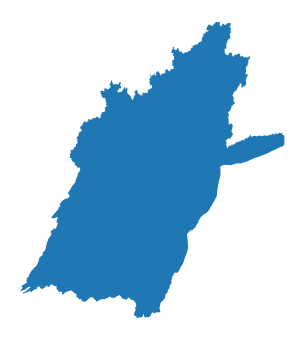

In [4]:
huc2 = pynhd.geoconnex(item="hu02", query={"HUC2": "02"})
ax = huc2.plot(figsize=(6, 6))
ax.set_axis_off()

GeoConnex, also supports spatial query. At the moment, it only accepts requesting features within a bounding box. For example, let's get all the stations within HUC02 that we previously retrieved.

In [5]:
gages = pynhd.geoconnex(item="gages", query={"geometry": huc2.geometry.iloc[0]})

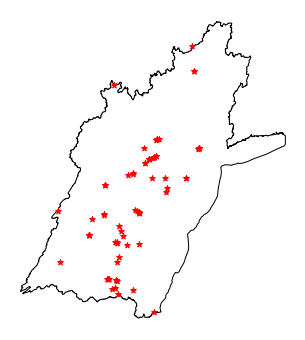

In [6]:
ax = huc2.plot(facecolor="none", edgecolor="black", figsize=(6, 6))
gages.plot(ax=ax, color="red", marker="*")
ax.set_axis_off()

Next, we want to retrieve the available data for a couple of USGS stations using the `GeoConnex` class.

In [7]:
gcx = GeoConnex()
gcx.item = "gages"  # instead we can instantiate the class like so GeoConnex("gages")
station_ids = ["01031450", "01031500", "01031510"]
gages = gpd.GeoDataFrame(
    pd.concat((gcx.query({"provider_id": sid}) for sid in station_ids), ignore_index=True),
    crs="epsg:4326",
)
gages

,geometry,fid,uri,name,description,subjectOf,provider,provider_id,nhdpv2_REACHCODE,nhdpv2_REACH_measure,nhdpv2_COMID,mainstem_uri
0,POINT (-69.45222 45.18444),58690,https://geoconnex.us/ref/gages/1077762,"Kingsbury Stream at Abbot Village, Maine",USGS NWIS Stream/River/Lake Site 01031450: Kin...,https://waterdata.usgs.gov/monitoring-location...,https://waterdata.usgs.gov,01031450,01020004001387,54.241330,1722913,https://geoconnex.us/ref/mainstems/2245317
1,POINT (-69.31472 45.17500),67663,https://geoconnex.us/ref/gages/1042227,"Piscataquis River near Dover-Foxcroft, Maine",USGS NWIS Stream/River/Lake Site 01031500: Pis...,https://waterdata.usgs.gov/monitoring-location...,https://waterdata.usgs.gov,01031500,01020004000247,0.942998,1722317,https://geoconnex.us/ref/mainstems/2244663
2,POINT (-69.23639 45.15028),43877,https://geoconnex.us/ref/gages/1039176,"Black Stream near Dover-Foxcroft, Maine",USGS NWIS Stream/River/Lake Site 01031510: Bla...,https://waterdata.usgs.gov/monitoring-location...,https://waterdata.usgs.gov,01031510,01020004000353,63.771800,1722933,https://geoconnex.us/ref/mainstems/2246031


Let's make a bit more advanced spatial query. Assume that we want to get all the stations within a 5-km radius of each the stations that we obtained above. First, we need to buffer the points by 5 km to create a multipolygon. Then we pass it as a query to `geoconnex`.

In [8]:
buff = gages.to_crs(5070).buffer(5e3).to_crs(4326)
gages = pynhd.geoconnex(item="gages", query={"geometry": buff.unary_union})

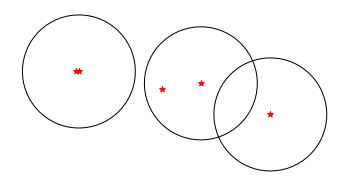

In [9]:
ax = buff.plot(facecolor="none", edgecolor="black", figsize=(6, 6))
gages.plot(ax=ax, color="red", marker="*")
ax.set_axis_off()